In [1]:
import molsysmt as msm
from molsysmt import pyunitwizard as puw
import omembrane as omem
import openmm as mm
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

from openmm import LocalEnergyMinimizer

In [2]:
molsys = msm.convert('memb_popc_100_stage_1.msmpk')

In [3]:
context = msm.convert(molsys, 'openmm.Context', platform='CUDA')

In [4]:
constant = 1000.0*u.kilojoules_per_mole/(u.nanometer**2)

system = context.getSystem()

harmonic_restraint = mm.CustomExternalForce('0.5*k*periodicdistance(x, y, z, x0, y0, z0)^2')
# harmonic_restraint = mm.CustomExternalForce('0.5*k*((x-x0)^2+(y-y0)^2+(z-z0)^2)') # no pbc
harmonic_restraint.addGlobalParameter('k', constant)
harmonic_restraint.addPerParticleParameter('x0')
harmonic_restraint.addPerParticleParameter('y0')
harmonic_restraint.addPerParticleParameter('z0')

_ = system.addForce(harmonic_restraint)

In [5]:
no_water_atoms = msm.select(molsys, selection='molecule_type!="water"')
no_water_coordinates = msm.get(context, element='atom', selection=no_water_atoms, coordinates=True)
no_water_coordinates = puw.convert(no_water_coordinates, to_form='openmm.unit')

In [6]:
for ii, atom_index in enumerate(no_water_atoms):
    harmonic_restraint.addParticle(atom_index, no_water_coordinates[0][ii])

In [7]:
coordinates = msm.get(context, coordinates=True)
context.reinitialize()
context.setPositions(puw.convert(coordinates[0], to_form='openmm.unit'))

In [8]:
P_atoms = msm.select(molsys, selection='atom_type=="P" and molecule_type=="lipid"')
N_atoms = msm.select(molsys, selection='atom_type=="N" and molecule_type=="lipid"')
C_atoms = msm.select(molsys, selection='atom_type=="C" and molecule_type=="lipid"')
OW_atoms = msm.select(molsys, selection='atom_type=="O" and molecule_type=="water"')

In [9]:
state_init = context.getState(getPositions=True)

In [10]:
msm.molecular_mechanics.get_potential_energy(context)

1.8142518882006257e+21 <Unit('kilojoule / mole')>

In [11]:
LocalEnergyMinimizer.minimize(context)

In [12]:
msm.molecular_mechanics.get_potential_energy(context)

-682600.375 <Unit('kilojoule / mole')>

In [13]:
state_end = context.getState(getPositions=True)

/home/diego/Myopt/miniconda3/envs/OMembrane@uibcdf_3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


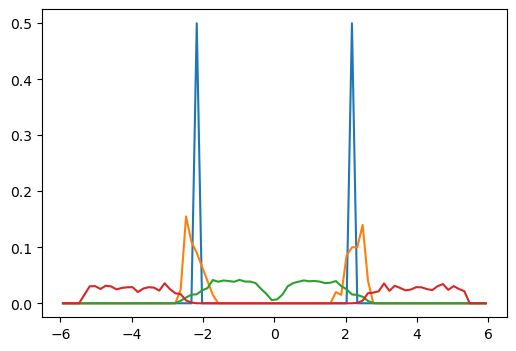

In [14]:
bins_edges_P_init, density_P_init = omem.analysis.get_lineal_density(state_init, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)
bins_edges_N_init, density_N_init = omem.analysis.get_lineal_density(state_init, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)
bins_edges_C_init, density_C_init = omem.analysis.get_lineal_density(state_init, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)

bins_edges_OW_init, density_OW_init = omem.analysis.get_lineal_density(state_init, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)


plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_init[1:]+bins_edges_P_init[:-1])/2, density_P_init)
plt.plot((bins_edges_N_init[1:]+bins_edges_N_init[:-1])/2, density_N_init)
plt.plot((bins_edges_C_init[1:]+bins_edges_C_init[:-1])/2, density_C_init)
plt.plot((bins_edges_OW_init[1:]+bins_edges_OW_init[:-1])/2, density_OW_init)
plt.show()

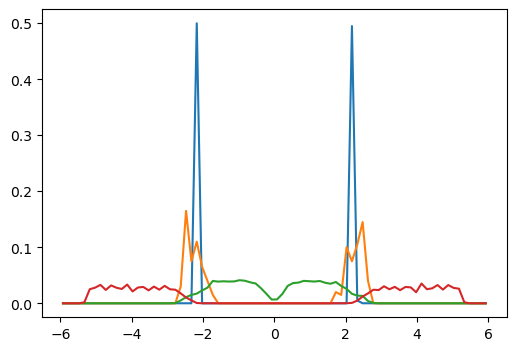

In [15]:
bins_edges_P_end, density_P_end = omem.analysis.get_lineal_density(state_end, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)
bins_edges_N_end, density_N_end = omem.analysis.get_lineal_density(state_end, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)
bins_edges_C_end, density_C_end = omem.analysis.get_lineal_density(state_end, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)

bins_edges_OW_end, density_OW_end = omem.analysis.get_lineal_density(state_end, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[-6.0, 6.0] nm", normalized=True)


plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_end[1:]+bins_edges_P_end[:-1])/2, density_P_end)
plt.plot((bins_edges_N_end[1:]+bins_edges_N_end[:-1])/2, density_N_end)
plt.plot((bins_edges_C_end[1:]+bins_edges_C_end[:-1])/2, density_C_end)
plt.plot((bins_edges_OW_end[1:]+bins_edges_OW_end[:-1])/2, density_OW_end)
plt.show()

In [16]:
shifts_P = msm.structure.get_distances(molecular_system=state_init, molecular_system_2=state_end,
                                       selection=P_atoms, pairs=True, pbc=True)
shifts_N = msm.structure.get_distances(molecular_system=state_init, molecular_system_2=state_end,
                                       selection=N_atoms, pairs=True, pbc=True)
shifts_C = msm.structure.get_distances(molecular_system=state_init, molecular_system_2=state_end,
                                       selection=C_atoms, pairs=True, pbc=True)
shifts_OW = msm.structure.get_distances(molecular_system=state_init, molecular_system_2=state_end,
                                       selection=OW_atoms, pairs=True, pbc=True)

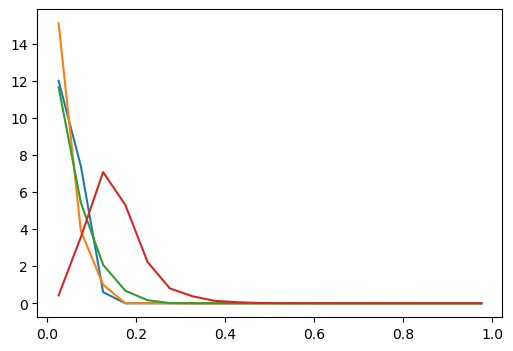

In [17]:
h_P, bins = np.histogram(puw.get_value(shifts_P[0]), range=[0.0, 1.0], bins=20, density=True)
h_N, bins = np.histogram(puw.get_value(shifts_N[0]), range=[0.0, 1.0], bins=20, density=True)
h_C, bins = np.histogram(puw.get_value(shifts_C[0]), range=[0.0, 1.0], bins=20, density=True)
h_OW, bins = np.histogram(puw.get_value(shifts_OW[0]), range=[0.0, 1.0], bins=20, density=True)
plt.plot(0.5*(bins[1:]+bins[:-1]), h_P)
plt.plot(0.5*(bins[1:]+bins[:-1]), h_N)
plt.plot(0.5*(bins[1:]+bins[:-1]), h_C)
plt.plot(0.5*(bins[1:]+bins[:-1]), h_OW)
plt.show()

In [18]:
forces = msm.molecular_mechanics.get_forces(context, norm=True)

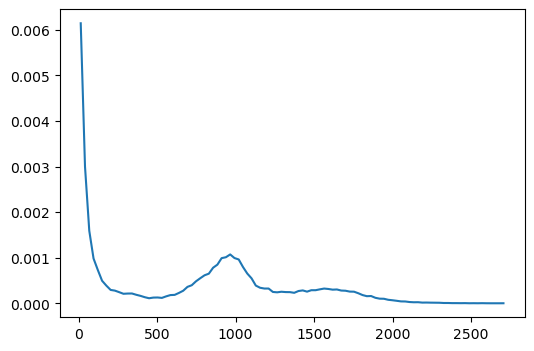

In [19]:
h, bins = np.histogram(puw.get_value(forces), bins=100, density=True)
plt.plot(0.5*(bins[1:]+bins[:-1]), h)
plt.show()

In [20]:
#memb_antes = msm.extract(molsys, selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')
#memb_despues = msm.extract([molsys, context], selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')

In [ ]:
#msm.view(memb_antes)

In [ ]:
#msm.view(memb_despues)

In [22]:
coordinates = msm.get(state_end, coordinates=True)
msm.set(molsys, coordinates=coordinates)

In [24]:
msm.convert(molsys, 'memb_popc_100_stage_2_1.msmpk')

'memb_popc_100_stage_2_1.msmpk'